# NDM model (direct fit)

This notebook predicts $\Delta$$\tau$ from clinical data following the NDM model:

### $\Delta$$\tau$ = $\beta$$L$$\tau_{BL}$

where $\beta$ is modelled as:

### model 1: $\beta$ = $a$$\sum$$\tau_{BL}$ 
### model 2: $\beta$ = $b$$\sum$$A_{BL}$
### model 3: $\beta$ = $a$$\sum$$\tau_{BL}$ + $b$$\sum$$A_{BL}$ + $c$$\sum$$\tau_{BL}$/$\sum$$A_{BL}$

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

## Preprocessing

### Load data from pickle

In [2]:
# Load data from pickle

with open('../data/pickle_data/AD_longitudinal.pkl', 'rb') as handle:
    AD_longitudinal = pickle.load(handle)
    
with open('../data/pickle_data/MCI_longitudinal.pkl', 'rb') as handle:
    MCI_longitudinal = pickle.load(handle)
    
with open('../data/pickle_data/CN_longitudinal.pkl', 'rb') as handle:
    CN_longitudinal = pickle.load(handle)
    
with open('../data/pickle_data/tau.pkl', 'rb') as handle:
    tau = pickle.load(handle)
    
with open('../data/pickle_data/diagnosis.pkl', 'rb') as handle:
    diagnosis = pickle.load(handle)
    
with open('../data/pickle_data/atrophy.pkl', 'rb') as handle:
    atrophy = pickle.load(handle)

with open('../data/pickle_data/mean_cortical_area.pkl', 'rb') as handle:
    mean_cortical_area = pickle.load(handle)
    
AD_MCI_tau_v1 = pd.concat([MCI_longitudinal['tau']['visit_1'], 
                          AD_longitudinal['tau']['visit_1']])
AD_MCI_tau_v3 = pd.concat([MCI_longitudinal['tau']['visit_3'],
                          AD_longitudinal['tau']['visit_3']])

# From previous calculation:
NDM_predicted_regions = ['rh_superiortemporal',
                         'lh_superiortemporal',
                         'rh_lateraloccipital',
                         'lh_lateraloccipital', 
                         'lh_precuneus',
                         'lh_superiorfrontal', 
                         'rh_precuneus', 
                         'rh_superiorfrontal',
                         'rh_bankssts',
                         'lh_pericalcarine',
                         'rh_pericalcarine', 
                         'lh_bankssts']

### Fix Laplacian ordering

Make sure the Laplacian ordering is the same as regions provided in the dataframe

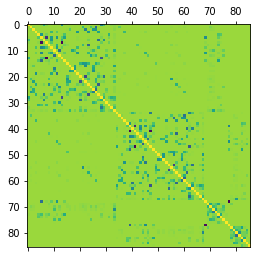

In [3]:
from cortography.utils import atlas_utils

# Load utility dataframe for DK regions
DK = atlas_utils.load_atlas('DK')

# Laplacian is currently LRRL. Let's make it LRLR, like Lilly's data
L = atlas_utils.load_laplacian(n=5)

# First change name convention to match Lilly's format
L = L.rename({L.columns[i]:DK.loc[L.columns[i]]['Other Name'] for i in range(len(L))}, axis=0)
L = L.rename({L.columns[i]:DK.loc[L.columns[i]]['Other Name'] for i in range(len(L))}, axis=1)
L = L.rename({'Right-VentralDC/Hypothalamus':'Right-VentralDC', 'Left-VentralDC/Hypothalamus':'Left-VentralDC'}, axis=0)
L = L.rename({'Right-VentralDC/Hypothalamus':'Right-VentralDC', 'Left-VentralDC/Hypothalamus':'Left-VentralDC'}, axis=1)

# Then reorder to match Lilly's LRLR order
L = L[tau.columns[1:]].loc[tau.columns[1:]]

#plot to confirm
plt.matshow(L[tau.columns[1:]].loc[tau.columns[1:]])
plt.show()

### Define some useful features
$$FBP = \sum_{n=1}^{n=68} A_\beta $$
$$TBT = \sum_{n=1}^{n=68} \tau_{BL} $$

In [4]:
# FBP
fbp = diagnosis['Florbetapir SUVr']
fbp = fbp.loc[AD_MCI_tau_v1.index]

# Sum of tau for cortical areas
cortical_regions = DK[DK['Cortex']=='cortical']['Other Name'].values
total_bl_tau = AD_MCI_tau_v1[cortical_regions].sum(axis=1)

# ratio
ratio = total_bl_tau / fbp

In [5]:
# FBP visual read for AD patients
fbp_visual = diagnosis['FBP Visual Read']
fbp_visual = fbp_visual.loc[AD_MCI_tau_v1.index]
fbp_visual_positive = fbp_visual[fbp_visual == 'Positive']
fbp_visual_negative = fbp_visual[fbp_visual == 'Negative']

#number of fbp patients
print('Number of fbp patients:', fbp_visual.shape[0])
print('Sum of + and -:', fbp_visual_positive.shape[0] + fbp_visual_negative.shape[0])

ad_fbp_visual_positive = list(set.intersection(set(fbp_visual_positive.index), set(AD_longitudinal['tau']['visit_1'].index)))
print('There are', len(ad_fbp_visual_positive), 'AD that are visual + for A-beta')

ad_fbp_visual_negative = set(AD_longitudinal['tau']['visit_1'].index) - set(ad_fbp_visual_positive)
print('There are', len(ad_fbp_visual_negative), 'AD that are visual - for A-beta')

mci_fbp_visual_positive = list(set.intersection(set(fbp_visual_positive.index), set(MCI_longitudinal['tau']['visit_1'].index)))
print('There are', len(mci_fbp_visual_positive), 'MCI that are visual + for A-beta')

mci_fbp_visual_negative = set(MCI_longitudinal['tau']['visit_1'].index) - set(mci_fbp_visual_positive)
print('There are', len(mci_fbp_visual_negative), 'MCI that are visual - for A-beta')


Number of fbp patients: 88
Sum of + and -: 88
There are 18 AD that are visual + for A-beta
There are 10 AD that are visual - for A-beta
There are 28 MCI that are visual + for A-beta
There are 32 MCI that are visual - for A-beta


### Scale data?

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scale_data = False

#min max scaling
if scale_data:
    scaler = StandardScaler()

    total_bl_tau = pd.DataFrame(total_bl_tau)
    total_bl_tau[0] = scaler.fit_transform(pd.DataFrame(total_bl_tau)).ravel()
    total_bl_tau = total_bl_tau[0]

    fbp = pd.DataFrame(fbp)
    fbp[0] = scaler.fit_transform(pd.DataFrame(fbp)).ravel()
    fbp = fbp[0]

    ratio = total_bl_tau / fbp

## Define useful functions

### Cohort selector

The following function makes it easy to select a particular patient cohort from a combination of clinical diagnosis and amyloid status.

In [8]:
def return_subject_ids_for_cohort(clinical_dx, amyloid_status):
    """
    given clinical dx and amyloid status, return a set of indices corresponding to the choice
    clinical_dx (str): AD, MCI, both
    amyloid_status (str): positive, negative, both   
    clinical_and_amyloid_set (set): indices of subjects matching request
    """
    ad_patients = set(AD_longitudinal['tau']['visit_1'].index)
    mci_patients = set(MCI_longitudinal['tau']['visit_1'].index)
    ad_mci_patients = ad_patients.union(mci_patients)

    fbp_positive = set(fbp_visual_positive.index)
    fbp_negative = set(fbp_visual_negative.index)
    fbp_positive_negative = fbp_positive.union(fbp_negative)
    
    if clinical_dx == 'AD':
        clinical_dx_set = ad_patients
    elif clinical_dx == 'MCI':
        clinical_dx_set = mci_patients
    elif clinical_dx == 'both':
        clinical_dx_set = ad_mci_patients
        
    if amyloid_status == 'positive':
        amyloid_status_set = fbp_positive
    elif amyloid_status == 'negative':
        amyloid_status_set = fbp_negative
    elif amyloid_status == 'both':
        amyloid_status_set = fbp_positive_negative
        
    clinical_and_amyloid_set = clinical_dx_set.intersection(amyloid_status_set)
    
    return(clinical_and_amyloid_set)

#### Make sure function does what we expect

In [9]:
#test / example:
#return_subject_ids_for_cohort

#assert AD, all amyloid
set_of_all_ADs = set(AD_longitudinal['tau']['visit_1'].index) 
assert(return_subject_ids_for_cohort(clinical_dx='AD', amyloid_status='both') == set_of_all_ADs)

#assert AD, + amyloid
set_of_all_ADs_fbp_positive = set(AD_longitudinal['tau']['visit_1'].loc[ad_fbp_visual_positive].index)
assert(return_subject_ids_for_cohort(clinical_dx='AD', amyloid_status='positive') == set_of_all_ADs_fbp_positive)

#assert AD, - amyloid
set_of_all_ADs_fbp_negative = set(AD_longitudinal['tau']['visit_1'].loc[ad_fbp_visual_negative].index)
assert(return_subject_ids_for_cohort(clinical_dx='AD', amyloid_status='negative') == set_of_all_ADs_fbp_negative)

#assert MCI, all amyloid
set_of_all_MCIs = set(MCI_longitudinal['tau']['visit_1'].index) 
assert(return_subject_ids_for_cohort(clinical_dx='MCI', amyloid_status='both') == set_of_all_MCIs)

#assert MCI, + amyloid
set_of_all_MCIs_fbp_positive = set(MCI_longitudinal['tau']['visit_1'].loc[mci_fbp_visual_positive].index)
assert(return_subject_ids_for_cohort(clinical_dx='MCI', amyloid_status='positive') == set_of_all_MCIs_fbp_positive)

#assert MCI, - amyloid
set_of_all_MCIs_fbp_negative = set(MCI_longitudinal['tau']['visit_1'].loc[mci_fbp_visual_negative].index)
assert(return_subject_ids_for_cohort(clinical_dx='MCI', amyloid_status='negative') == set_of_all_MCIs_fbp_negative)

#assert AD+MCI, all amyloid
set_of_all_subjects = set_of_all_ADs.union(set_of_all_MCIs) 
assert(return_subject_ids_for_cohort(clinical_dx='both', amyloid_status='both') == set_of_all_subjects)

### Get longitudinal data

In [10]:
def get_longitudinal_data(clinical_dx, amyloid_status):
    """
    clinical_dx (str): AD, MCI, both
    amyloid_status (str): positive, negative, both            
    
    returns: dictionary with 2 indices: 'baseline' and '18_months' containing tau data.
    """
    try:
        #create subgroups of patients
        subject_IDs = return_subject_ids_for_cohort(clinical_dx=clinical_dx, 
                                                    amyloid_status=amyloid_status)

        AD_v1 = AD_longitudinal['tau']['visit_1']
        AD_v3 = AD_longitudinal['tau']['visit_3']

        MCI_v1 = MCI_longitudinal['tau']['visit_1']
        MCI_v3 = MCI_longitudinal['tau']['visit_3']

        AD_MCI_v1 = pd.concat([AD_v1, MCI_v1])
        AD_MCI_v3 = pd.concat([AD_v3, MCI_v3])    

        subjects_v1 = AD_MCI_v1.loc[subject_IDs]
        subjects_v3 = AD_MCI_v3.loc[subject_IDs]

    except:
        raise TypeError('subject option not recognized')
    
    return({'baseline':subjects_v1, 
            '18_months':subjects_v3})

In [11]:
# test get_longitudinal_data
assert(len(get_longitudinal_data(clinical_dx='AD', amyloid_status='positive')['baseline']) == 18)
assert(len(get_longitudinal_data(clinical_dx='AD', amyloid_status='negative')['baseline']) == 10)

assert(len(get_longitudinal_data(clinical_dx='MCI', amyloid_status='positive')['baseline']) == 28)
assert(len(get_longitudinal_data(clinical_dx='MCI', amyloid_status='negative')['baseline']) == 32)

### Construct model

$$\Delta\tau = (\alpha.\sum_{n=1}^{n=68} \tau + \beta.\sum_{n=1}^{n=68} A_\beta + \gamma.(\sum_{n=1}^{n=68} \tau )/ (\sum_{n=1}^{n=68} A_\beta))\sum_{n=1}^{n=86} L.\tau_{BL} $$

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2

What the model below does is to create a vector X containing each term in the equation above.
This vector will be fit via linear regression against the measured delta_tau Y and $\alpha \beta \gamma$ will be found.

In [13]:
def make_regression_variables(clinical_dx, amyloid_status, model, 
                              regions_to_average=None,
                              weight_variable_by_region_area=False):
    """
    clinical_dx (str): AD, MCI, both
    amyloid_status (str): positive, negative, both            
    model (int):
        0: Δτ = a.τ
        1: Δτ = b.Aβ
        2: Δτ = a.τ + b.Aβ
        3: Δτ = a.τ + b.Aβ + c.(τ / Aβ)
    regions_to_average (list): regions over which X,Y will be averaged over
    strict_AD_selection (bool): If True, only include amyloid + cases in AD cohort
    weight_variable_by_region_area = If True, (cortical) feature will be averaged by region area
    """

    subjects_dictionary = get_longitudinal_data(clinical_dx=clinical_dx, amyloid_status=amyloid_status)
    subjects_v1, subjects_v3 = subjects_dictionary['baseline'], subjects_dictionary['18_months']
    
    X_vec = []
    Y_vec = []
    corticals = list(cortical_regions)
    for p_idx in subjects_v1.index:
        X0 = np.matmul(L, subjects_v1.loc[p_idx])
        X0 = X0[corticals]
        
        y = subjects_v3.loc[p_idx] - subjects_v1.loc[p_idx]
        y = y[corticals]
        
        # average select group of regions, if desired
        if regions_to_average != None:
            if weight_variable_by_region_area:
                try:
                    #average according to area
                    X0 = (X0*mean_cortical_area[regions_to_average]).sum()
                    X0 = X0/(mean_cortical_area[regions_to_average].sum())

                    y = (y*mean_cortical_area[regions_to_average]).sum()
                    y = y/(mean_cortical_area[regions_to_average].sum())
                except:
                    print("Couldn't get region mean. Is this a subcortical region?")
            else:
                X0 = X0[regions_to_average].mean()
                y = y[regions_to_average].mean()
            
        if model == 0:
            X = np.array([X0*total_bl_tau[p_idx]])
        elif model == 1:
            X = np.array([X0*fbp[p_idx]])
        elif model == 2:
            X = np.array([X0*total_bl_tau[p_idx], X0*fbp[p_idx]])
        elif model == 3:
            X = np.array([X0*total_bl_tau[p_idx], X0*fbp[p_idx], X0*ratio[p_idx]])
        else:
            raise ValueError('model number out of range')
        #reshape X array so regression parameters are together
        if regions_to_average == None:
            for i in range(X.shape[1]):
                X_vec.append([X[j][i] for j in range(len(X))])
        else:
            X_vec.append(X)

        Y_vec.append(y)
        
    X_vec = np.array(X_vec)
    Y_vec = np.array(Y_vec).reshape(-1, 1)
    return({'X':X_vec, 'Y':Y_vec, 'idx':subjects_v1.index})    

In [14]:
#usage:
make_regression_variables(clinical_dx='AD',amyloid_status='positive', model=3, 
                          regions_to_average=None, weight_variable_by_region_area=True)

{'X': array([[ -762.23293807,   -15.5796206 ,  -476.3955863 ],
        [ -538.69078535,   -11.01054237,  -336.68174085],
        [ -573.59302308,   -11.72392485,  -358.49563942],
        ...,
        [ -751.27347369,   -12.39286984,  -536.62390978],
        [ -699.89887283,   -11.54540382,  -499.92776631],
        [-1370.47129348,   -22.60704384,  -978.90806677]]),
 'Y': array([[ 0.14],
        [ 0.02],
        [ 0.24],
        ...,
        [ 0.11],
        [-0.03],
        [ 0.07]]),
 'idx': Int64Index([ 59968, 944417, 924322, 125928, 470889,  93322, 824747, 771468,
             638383, 128400,  32753, 302547, 381301, 682518, 160855, 757241,
             572507, 265436],
            dtype='int64', name='Randomized ID')}

In [15]:
def select_subset_of_regression_variables(cohort_dict, clinical_dx='both', amyloid_status='both'):
    """ 
    Given a dictionary of regression variables from `make_regression_variables`
    return those matching desired clinical_dx and amyloid_status filter.
    
    Needed for fancy plotting purposes only (subsets are different shape / color)
    """
    ids_of_interest = return_subject_ids_for_cohort(clinical_dx=clinical_dx,
                                                    amyloid_status=amyloid_status)   
    select_cohort = {}
    if 'idx' not in cohort_dict.keys():
        raise NameError('idx key must be included in cohort_dict')

    for key in cohort_dict.keys():
        key_dict = pd.DataFrame(cohort_dict[key]).set_index(cohort_dict['idx'])
        key_dict = key_dict.loc[ids_of_interest]
        if key != 'idk':
            key_dict = np.array(key_dict)
        select_cohort[key] = key_dict
    select_cohort['idx'] = pd.Index(select_cohort['idx'].ravel()) 
    return(select_cohort)

In [16]:
# test select_subset_of_regression_variables function:

#TODO: this only works if regions_to_average == True
regression_dict = make_regression_variables(clinical_dx='both',
                                            amyloid_status='both', 
                                            model=3, 
                                            regions_to_average=list(cortical_regions), 
                                            weight_variable_by_region_area=False)

ad_fbp_positive_idxs_1 = set.intersection(set(fbp_visual_positive.index), set(AD_longitudinal['tau']['visit_1'].index))
ad_fbp_positive_idxs_2 = select_subset_of_regression_variables(regression_dict, clinical_dx='AD', amyloid_status='positive')['idx']
assert(ad_fbp_positive_idxs_1 == set(ad_fbp_positive_idxs_2))

ad_fbp_negative_idxs_1 = set.intersection(set(fbp_visual_negative.index), set(AD_longitudinal['tau']['visit_1'].index))
ad_fbp_negative_idxs_2 = select_subset_of_regression_variables(regression_dict, clinical_dx='AD', amyloid_status='negative')['idx']
assert(ad_fbp_negative_idxs_1 == set(ad_fbp_negative_idxs_2))

mci_fbp_positive_idxs_1 = set.intersection(set(fbp_visual_positive.index), set(MCI_longitudinal['tau']['visit_1'].index))
mci_fbp_positive_idxs_2 = select_subset_of_regression_variables(regression_dict, clinical_dx='MCI', amyloid_status='positive')['idx']
assert(mci_fbp_positive_idxs_1 == set(mci_fbp_positive_idxs_2))

mci_fbp_negative_idxs_1 = set.intersection(set(fbp_visual_negative.index), set(MCI_longitudinal['tau']['visit_1'].index))
mci_fbp_negative_idxs_2 = select_subset_of_regression_variables(regression_dict, clinical_dx='MCI', amyloid_status='negative')['idx']
assert(mci_fbp_negative_idxs_1 == set(mci_fbp_negative_idxs_2))

In [17]:
#example usage
select_subset_of_regression_variables(regression_dict, clinical_dx='AD', amyloid_status='positive')

{'X': array([[ -878.93074678,   -17.96485941,  -549.33171674],
        [ -647.26783985,   -12.41968635,  -501.75801539],
        [ -954.35798986,   -16.88714064,  -662.74860407],
        [ -624.25475858,   -10.77605125,  -547.5918935 ],
        [-1410.05872097,   -15.75164612, -1281.87156451],
        [-1182.93303117,   -17.91728306,  -863.45476728],
        [ -936.40012382,   -17.13353475,  -637.00688695],
        [ -620.44516117,   -13.87850368,  -424.96243915],
        [ -678.33194475,   -15.25115338,  -437.63351274],
        [-1071.48019749,   -18.71743519,  -709.58953476],
        [ -942.17826106,   -20.71238745,  -535.32855742],
        [ -651.74444452,   -16.05521549,  -394.99663304],
        [ -677.55941342,   -15.08535947,  -442.84928982],
        [ -761.38855402,   -13.44986681,  -594.83480783],
        [-1287.65663821,   -18.55688278,  -946.80635162],
        [-1061.3432669 ,   -20.40805438,  -647.1605286 ],
        [-1467.55423932,   -23.1726713 ,  -917.22139958],
        [

## Run the models

0.13577320305573803
0.15215507263766903
0.15536949233086694
0.25430824486421777


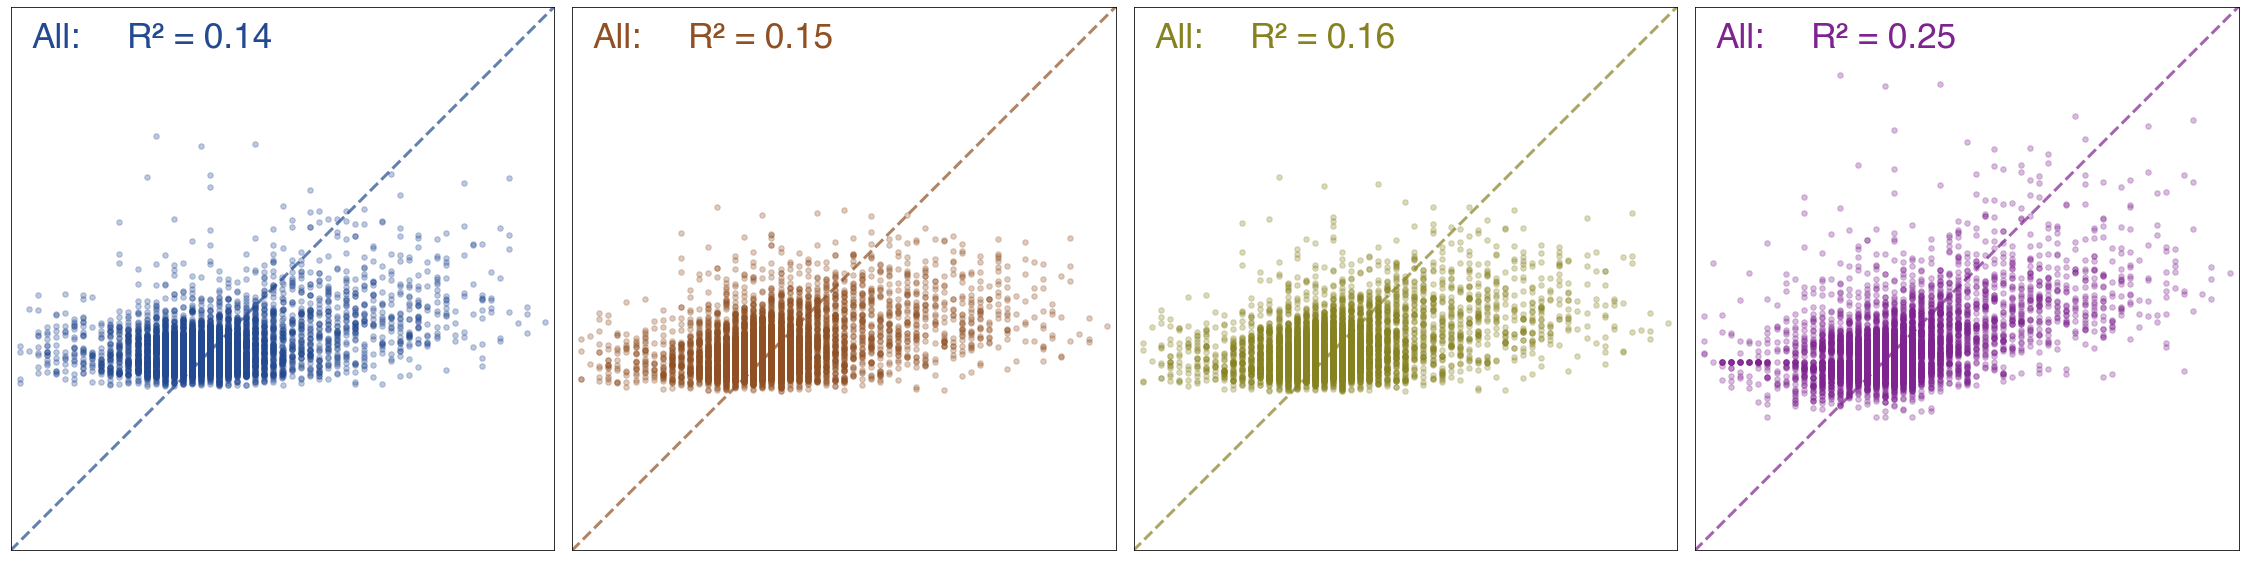

In [297]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']
for m in range(4):
    regression_dict = make_regression_variables(clinical_dx='both',
                                        amyloid_status='both', 
                                        model=m, 
                                        regions_to_average=None, 
                                        weight_variable_by_region_area=False)
    
    X,Y = regression_dict['X'], regression_dict['Y']
    model = LinearRegression(fit_intercept=True, normalize=True)
    model.fit(X, Y)
    
    score = r2(Y.ravel(), model.predict(X).ravel())
    print(score)

    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
#     plt.xlabel(r'$\Delta\tau_{true}$', fontsize=24)
#     plt.ylabel(r'$\Delta\tau_{predicted}$', fontsize=24)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(Y.ravel(), model.predict(X).ravel(), color=colors[m], s=30, alpha=0.3)
    plt.xlim([-0.2,0.4])
    plt.ylim([-0.2,0.4])
    plt.plot([-0.4,0.4],[-0.4,0.4],'--', color=colors[m],linewidth=3, alpha=0.7)
    
    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.177,0.355, 'All:', fontdict=fontdict)
    plt.text(-0.072,0.355, "R² = "+'{:.2f}'.format(score), fontdict=fontdict)

plt.savefig('../results/notebook_figs/M1-all_dx-AD_abeta-all_regions-all_average-n_tick-y.png', 
            dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

## Run bootstrap models

In [54]:
from sklearn.utils import resample

In [55]:
def calculate_bootstrap_samples(X, Y):
    """
    Runs 5000 linear regression models for bootstrapped samples of X and Y.
    Returns a dictionary with X, Y, predictions, models and scores.
    """
    num_repeats = 5000
    bootstrapped_models = []
    bootstrapped_scores = []
    
    for trial in range(num_repeats):
        X_sampled = resample(X, replace=True, n_samples=len(X), random_state=trial)
        Y_sampled = resample(Y, replace=True, n_samples=len(Y), random_state=trial)
        model = LinearRegression().fit(X_sampled, Y_sampled)
        score = r2(Y_sampled.ravel(), model.predict(X_sampled).ravel())

        bootstrapped_models.append(model)
        bootstrapped_scores.append(score)
        
    bootstrapped_preds = []
    for i in range(len(X)):
        x,y = X[i], Y[i]
        y_pred = np.array([model.predict([x]).ravel() for model in bootstrapped_models])
        bootstrapped_preds.append(y_pred)
    bootstrapped_preds = np.array(bootstrapped_preds)
    
    return({'X':X, 'Y':Y, 
            'predictions':bootstrapped_preds, 
            'models':bootstrapped_models,
            'scores':bootstrapped_scores})

### Mean over cortical regions

0.16 ,0.14
0.04 ,0.05
0.20 ,0.13
0.22 ,0.13


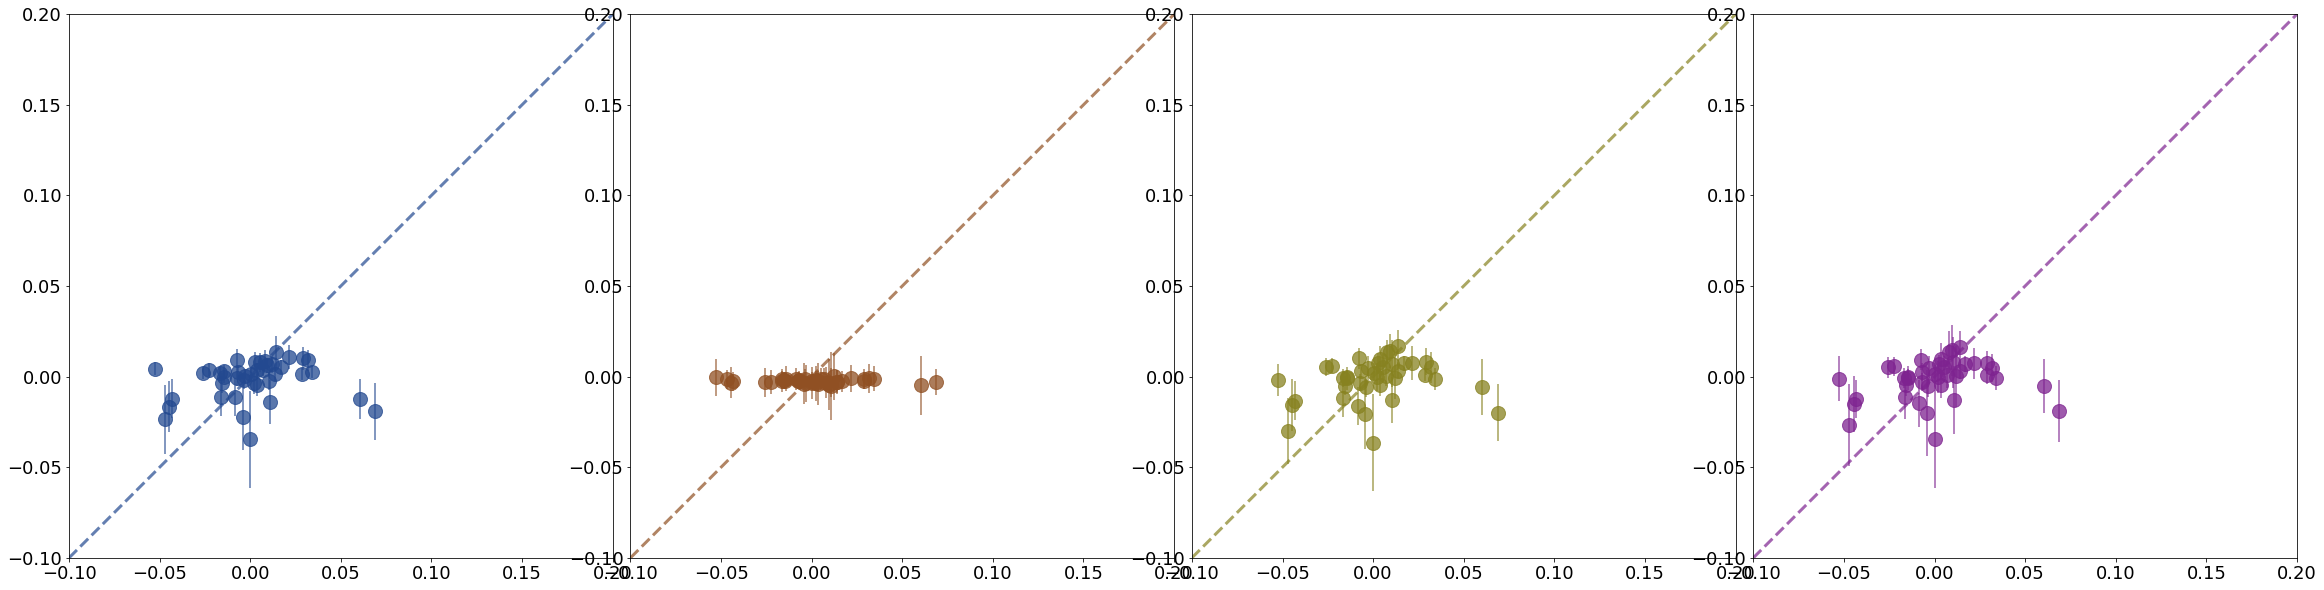

In [76]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'both'
amyloid_status = 'negative'
plot_with_ticks = True
plot = True

for m in range(4):
    model = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(cortical_regions), 
                                      weight_variable_by_region_area=True)
   
    X, Y = model['X'], model['Y']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()
    
    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()
    
    print('{:.2f}'.format(mean_score), ',{:.2f}'.format(std_score))
    
    if plot == True:
        plt.subplot(1,4,m+1, aspect=1.0)
        plt.subplots_adjust(wspace=0.025)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if not plot_with_ticks:
            plt.xticks([])
            plt.yticks([])

        plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

        plt.xlim([-0.10,0.20])
        plt.ylim([-0.10,0.20])
        plt.plot([-0.10,0.20],[-0.10,0.20],'--', color=colors[m], linewidth=3, alpha=0.7)


$R^2$ = 0.44 $R^2$ = 0.11
$R^2$ = 0.47 $R^2$ = 0.08
$R^2$ = 0.53 $R^2$ = 0.09
$R^2$ = 0.55 $R^2$ = 0.09


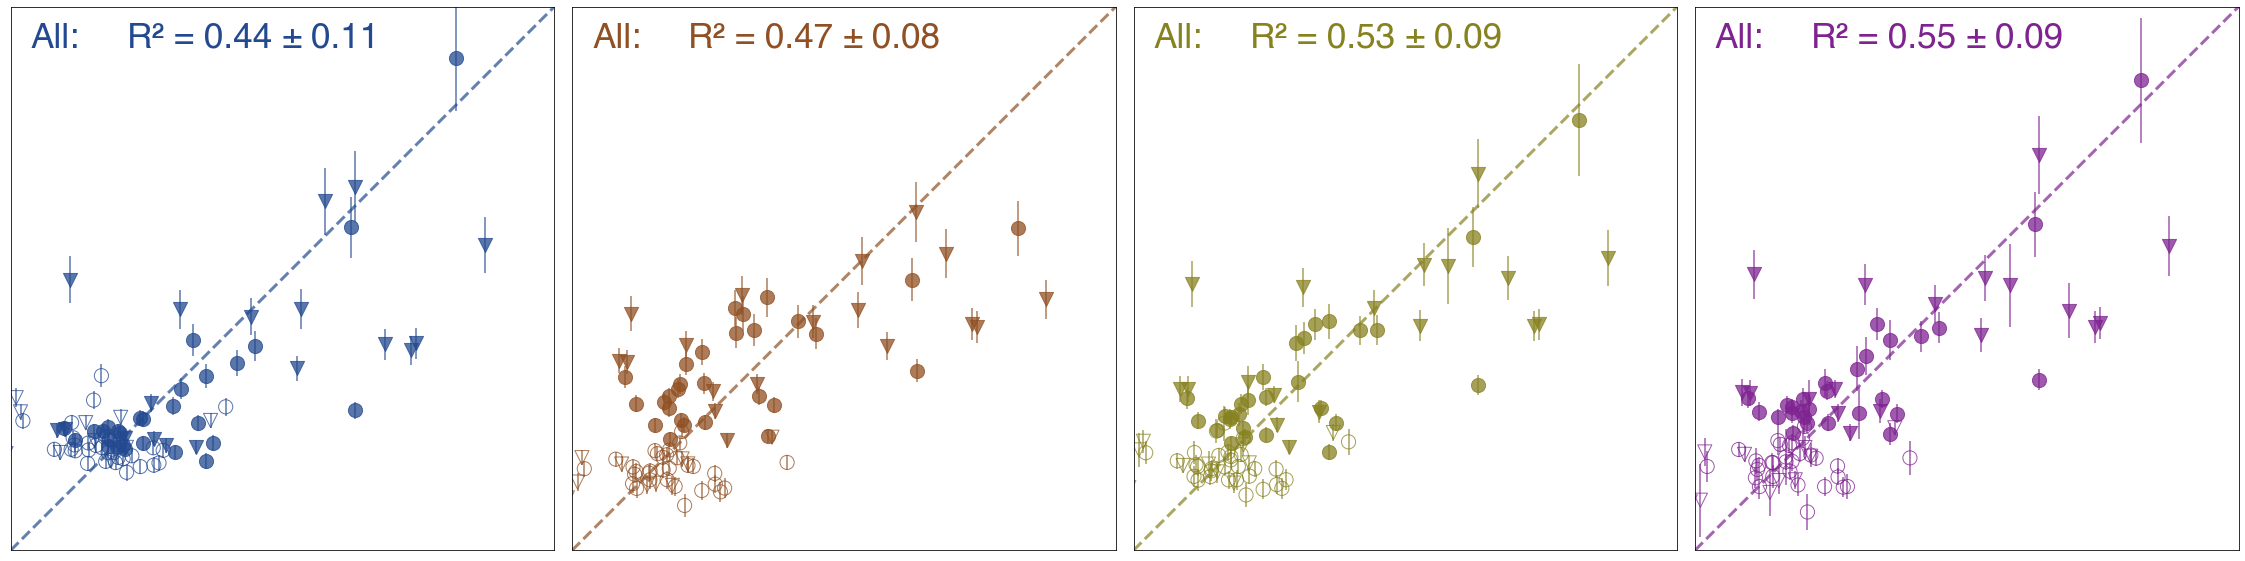

In [294]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'both'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(cortical_regions), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v','o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.05,0.25])
    plt.ylim([-0.05,0.25])
    plt.plot([-0.05,0.25],[-0.05,0.25],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD', 'MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.039,0.2275, 'All:', fontdict=fontdict)
    plt.text(0.014,0.2275, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M1-cortical_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

### Mean over Braak V regions

In [156]:
braak_5_regions = DK[ (DK['Braak stage']==5.0) & (DK['Cortex']=='cortical')]['Other Name']

In [158]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']
plot_with_ticks = True
plot = False

clinical_dx_options = ['both', 'AD', 'MCI', 'both','both']
amyloid_status_options = ['both', 'both', 'both', 'positive', 'negative']

for i in range(5):
    clinical_dx = clinical_dx_options[i]
    amyloid_status = amyloid_status_options[i]
    print(clinical_dx+' '+amyloid_status)
    
    for m in range(4):
        model = make_regression_variables(clinical_dx=clinical_dx,
                                          amyloid_status=amyloid_status, 
                                          model=m, 
                                          regions_to_average=list(braak_5_regions), 
                                          weight_variable_by_region_area=True)

        X, Y = model['X'], model['Y']

        bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
        scores = np.array(bootstrapped_data['scores'])
        mean_score = scores.mean()
        std_score = scores.std()

        preds = bootstrapped_data['predictions']
        means = preds.mean(axis=1).ravel()
        stds = preds.std(axis=1).ravel()

        print('{:.2f}'.format(mean_score), '± {:.2f}'.format(std_score))

        if plot == True:
            plt.subplot(1,4,m+1, aspect=1.0)
            plt.subplots_adjust(wspace=0.025)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            if not plot_with_ticks:
                plt.xticks([])
                plt.yticks([])

            plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

            plt.xlim([-0.10,0.20])
            plt.ylim([-0.10,0.20])
            plt.plot([-0.10,0.20],[-0.10,0.20],'--', color=colors[m], linewidth=3, alpha=0.7)

both both
0.48 ± 0.10
0.48 ± 0.08
0.55 ± 0.09
0.57 ± 0.08
AD both
0.50 ± 0.11
0.53 ± 0.10
0.60 ± 0.10
0.61 ± 0.10
MCI both
0.40 ± 0.21
0.38 ± 0.13
0.47 ± 0.17
0.51 ± 0.17
both positive
0.54 ± 0.10
0.44 ± 0.09
0.57 ± 0.10
0.58 ± 0.10
both negative
0.16 ± 0.14
0.04 ± 0.05
0.18 ± 0.13
0.21 ± 0.13


<Figure size 2880x720 with 0 Axes>

$R^2$ = 0.48 $R^2$ = 0.10
$R^2$ = 0.48 $R^2$ = 0.08
$R^2$ = 0.55 $R^2$ = 0.09
$R^2$ = 0.57 $R^2$ = 0.08


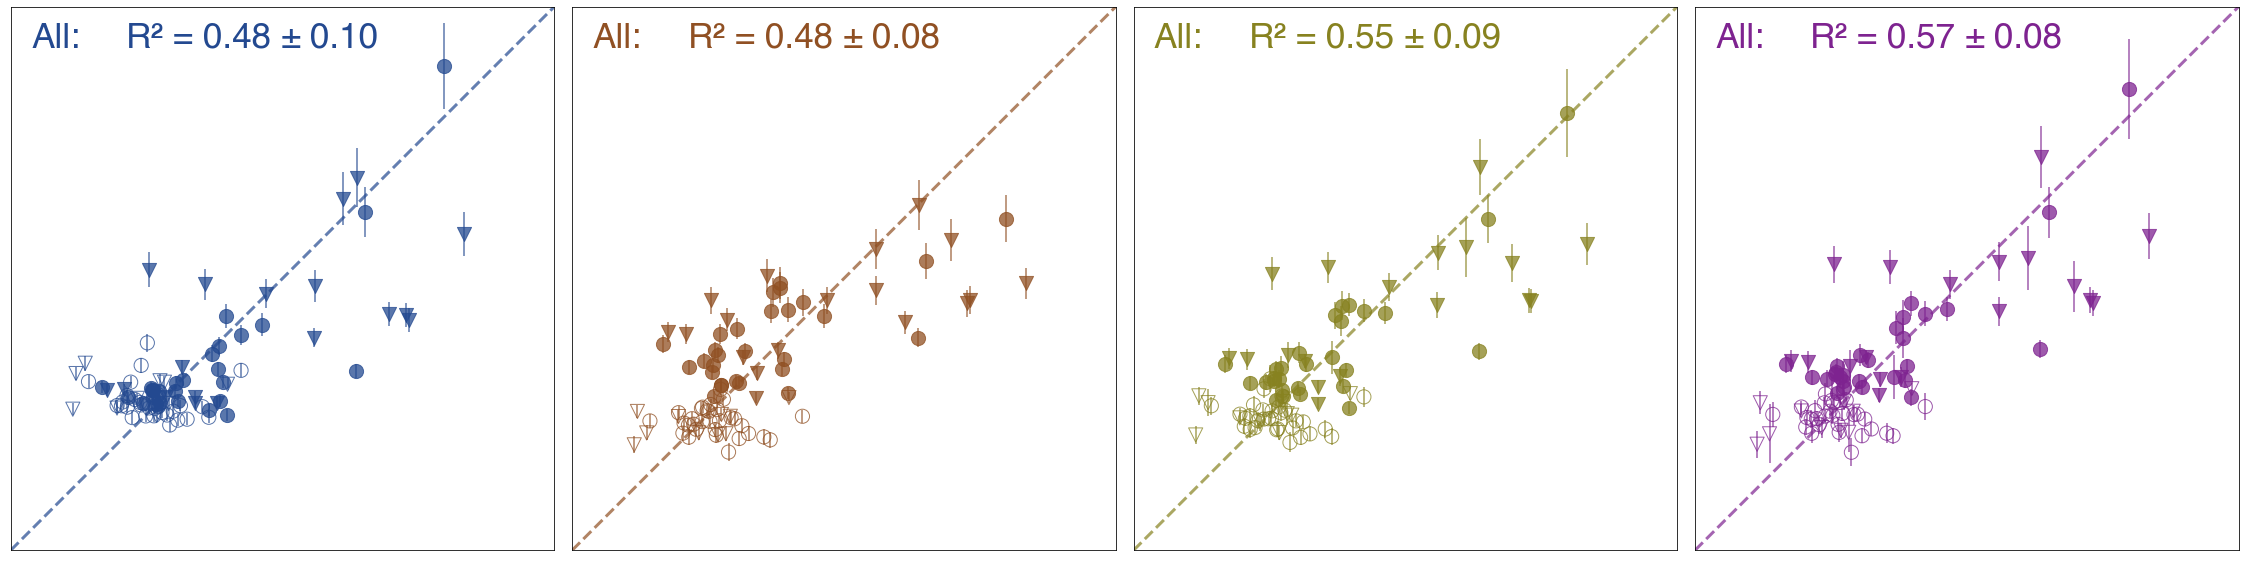

In [290]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'both'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(braak_5_regions), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v','o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD', 'MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.085,0.270, 'All:', fontdict=fontdict)
    plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
#     plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
#     plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M1-braak5_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

## Mean over NDM-selected regions

### NDM regions 1-8

In [289]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'AD'
amyloid_status = 'positive'
plot_with_ticks = True
plot = True

for m in range(4):
    model = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:4]), 
                                      weight_variable_by_region_area=True)
   
    X, Y = model['X'], model['Y']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()
    
    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()
    
    print('{:.2f}'.format(mean_score), ',{:.2f}'.format(std_score))
    
    if plot == True:
        plt.subplot(1,4,m+1, aspect=1.0)
        plt.subplots_adjust(wspace=0.025)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if not plot_with_ticks:
            plt.xticks([])
            plt.yticks([])

        plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

        plt.xlim([-0.10,0.3])
        plt.ylim([-0.10,0.3])

        plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

$R^2$ = 0.53 $R^2$ = 0.12
$R^2$ = 0.55 $R^2$ = 0.10
$R^2$ = 0.62 $R^2$ = 0.10
$R^2$ = 0.64 $R^2$ = 0.11


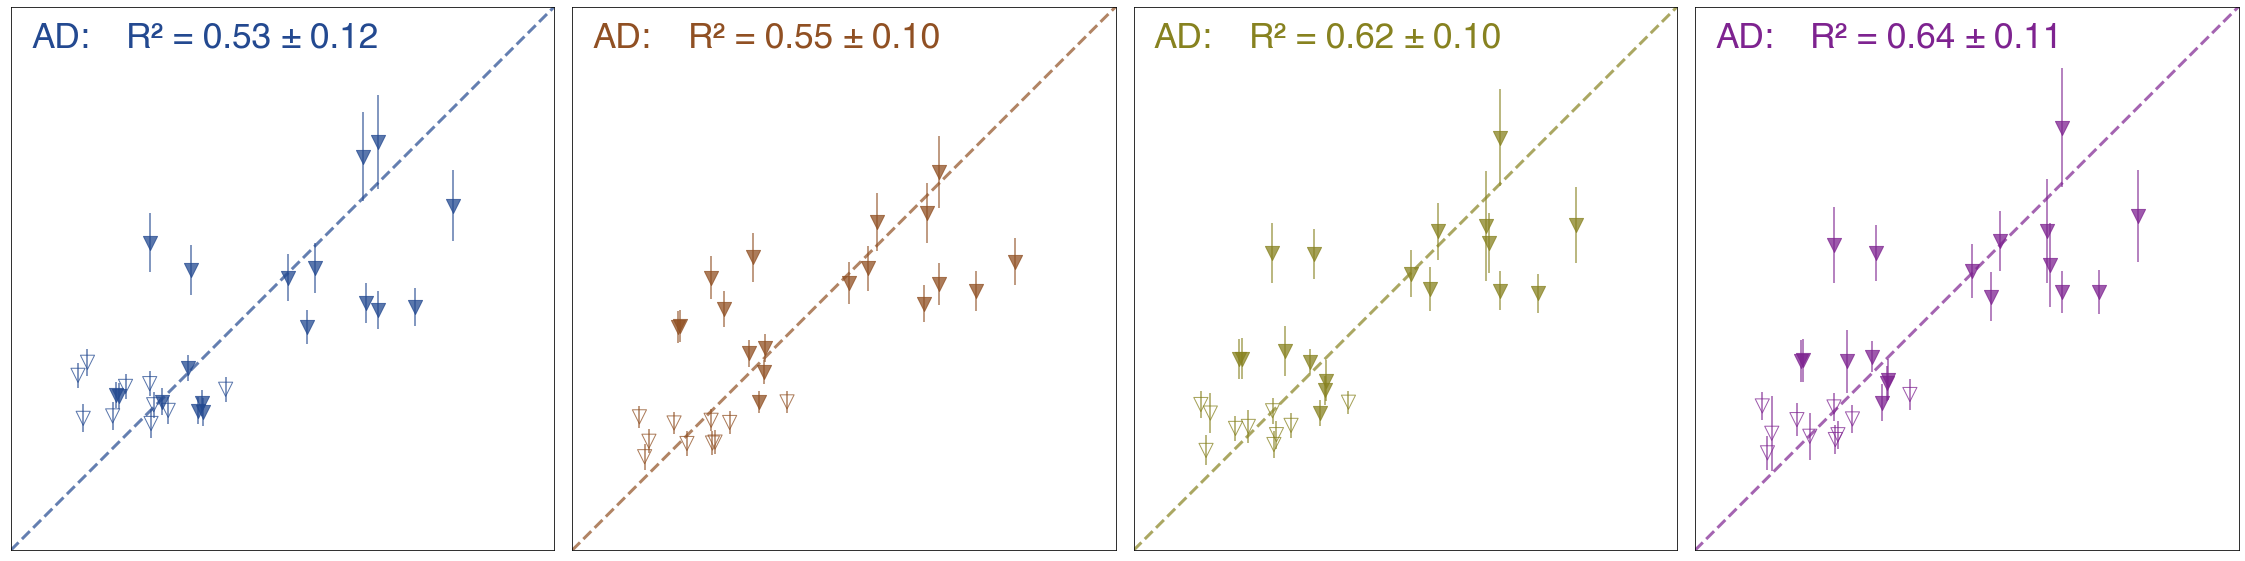

In [283]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'AD'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:8]), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1
    
    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
    plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
#     plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
#     plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M1_regions-1-8_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

$R^2$ = 0.41 $R^2$ = 0.21
$R^2$ = 0.38 $R^2$ = 0.13
$R^2$ = 0.48 $R^2$ = 0.17
$R^2$ = 0.51 $R^2$ = 0.17


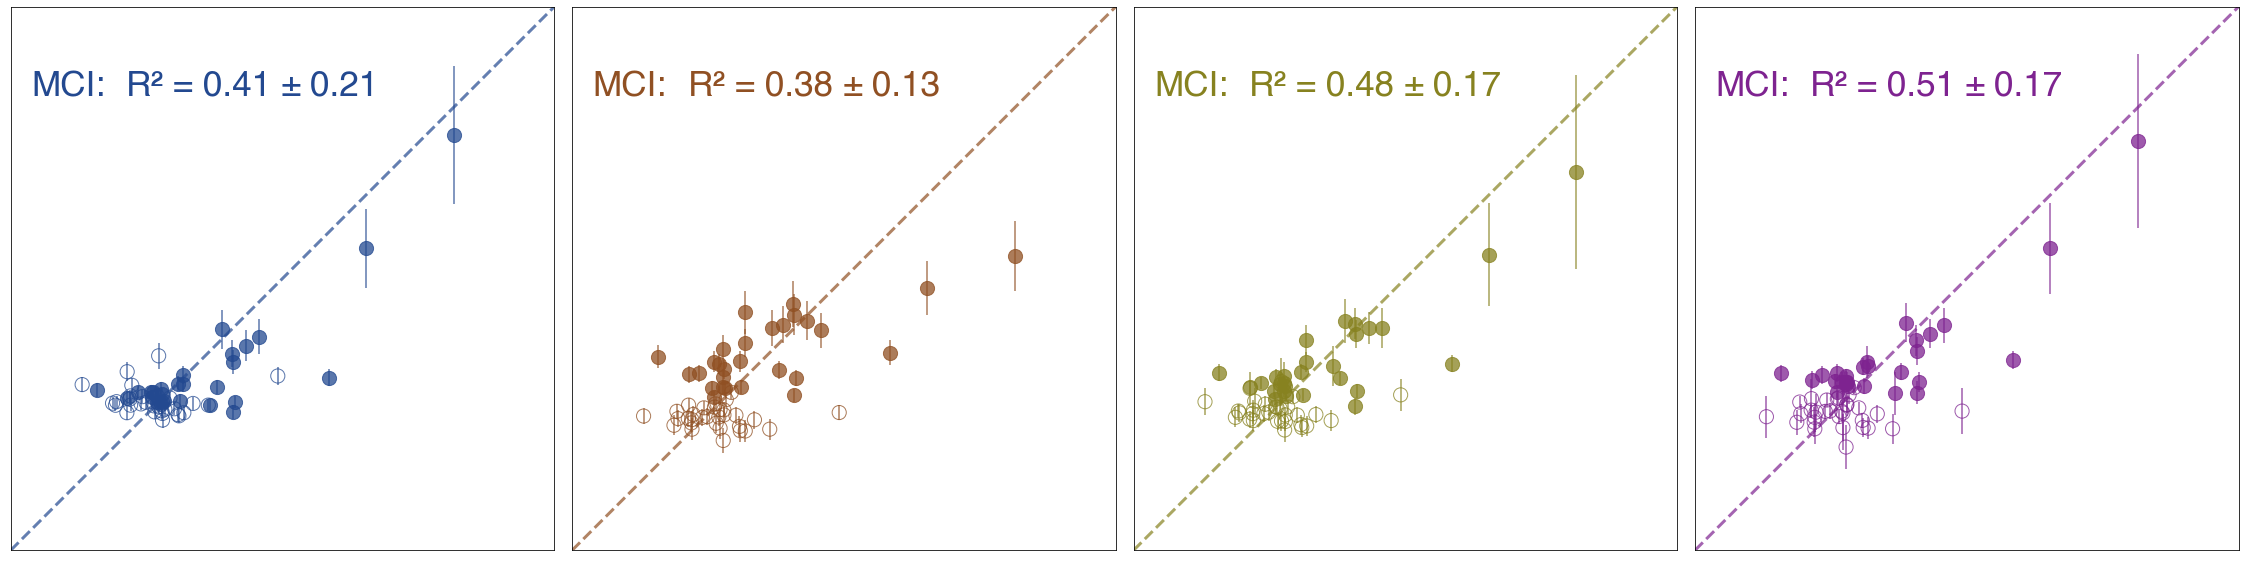

In [284]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'MCI'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:8]), 
                                      weight_variable_by_region_area=True)

    markers = ['o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
#     plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
#     plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
    plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
    plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M1_regions-1-8_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

### NDM regions 1-4

0.12 ,0.14
0.03 ,0.03
0.14 ,0.15
0.18 ,0.15


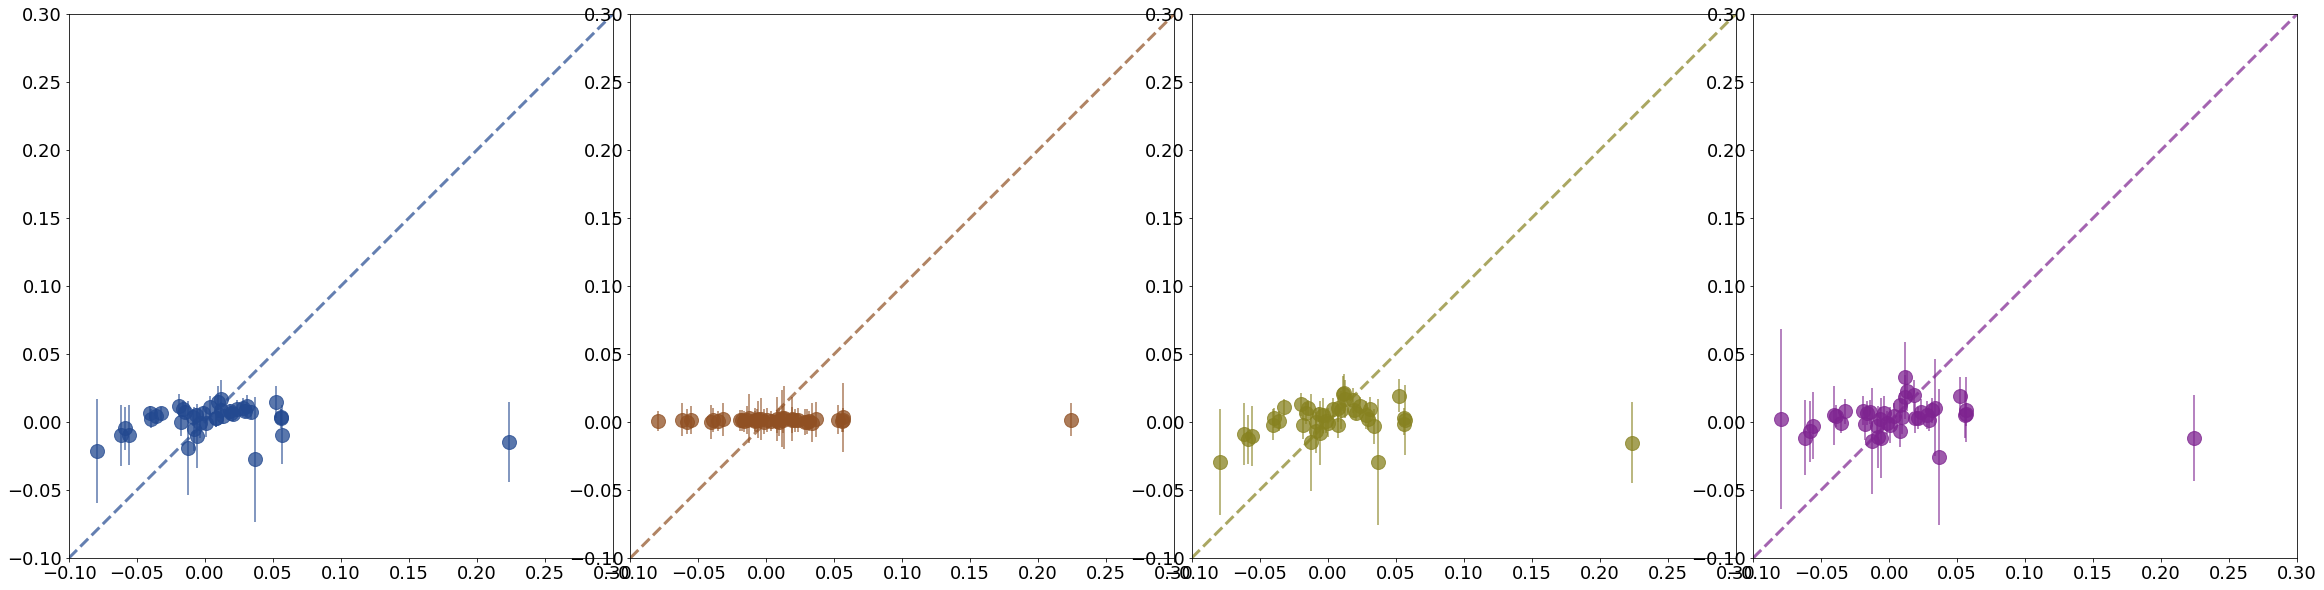

In [94]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'both'
amyloid_status = 'negative'
plot_with_ticks = True
plot = True

for m in range(4):
    model = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:4]), 
                                      weight_variable_by_region_area=True)
   
    X, Y = model['X'], model['Y']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()
    
    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()
    
    print('{:.2f}'.format(mean_score), ',{:.2f}'.format(std_score))
    
    if plot == True:
        plt.subplot(1,4,m+1, aspect=1.0)
        plt.subplots_adjust(wspace=0.025)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if not plot_with_ticks:
            plt.xticks([])
            plt.yticks([])

        plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

        plt.xlim([-0.10,0.3])
        plt.ylim([-0.10,0.3])
        plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

$R^2$ = 0.55 $R^2$ = 0.13
$R^2$ = 0.63 $R^2$ = 0.11
$R^2$ = 0.67 $R^2$ = 0.10
$R^2$ = 0.71 $R^2$ = 0.11


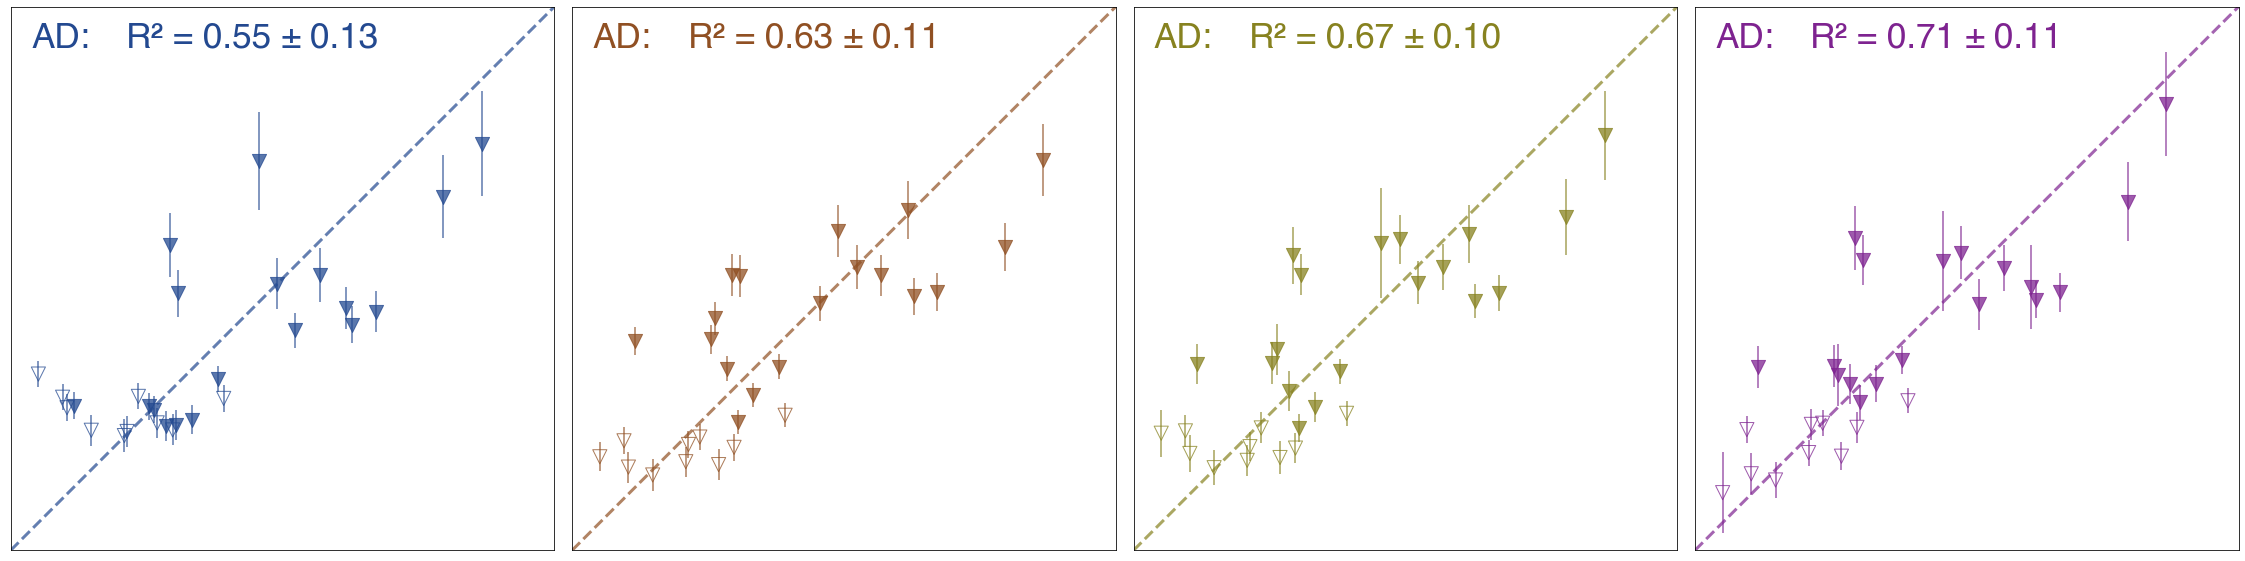

In [285]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'AD'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:4]), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
    plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
#     plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
#     plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M1_regions-1-4_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

$R^2$ = 0.21 $R^2$ = 0.12
$R^2$ = 0.22 $R^2$ = 0.12
$R^2$ = 0.26 $R^2$ = 0.12
$R^2$ = 0.27 $R^2$ = 0.13


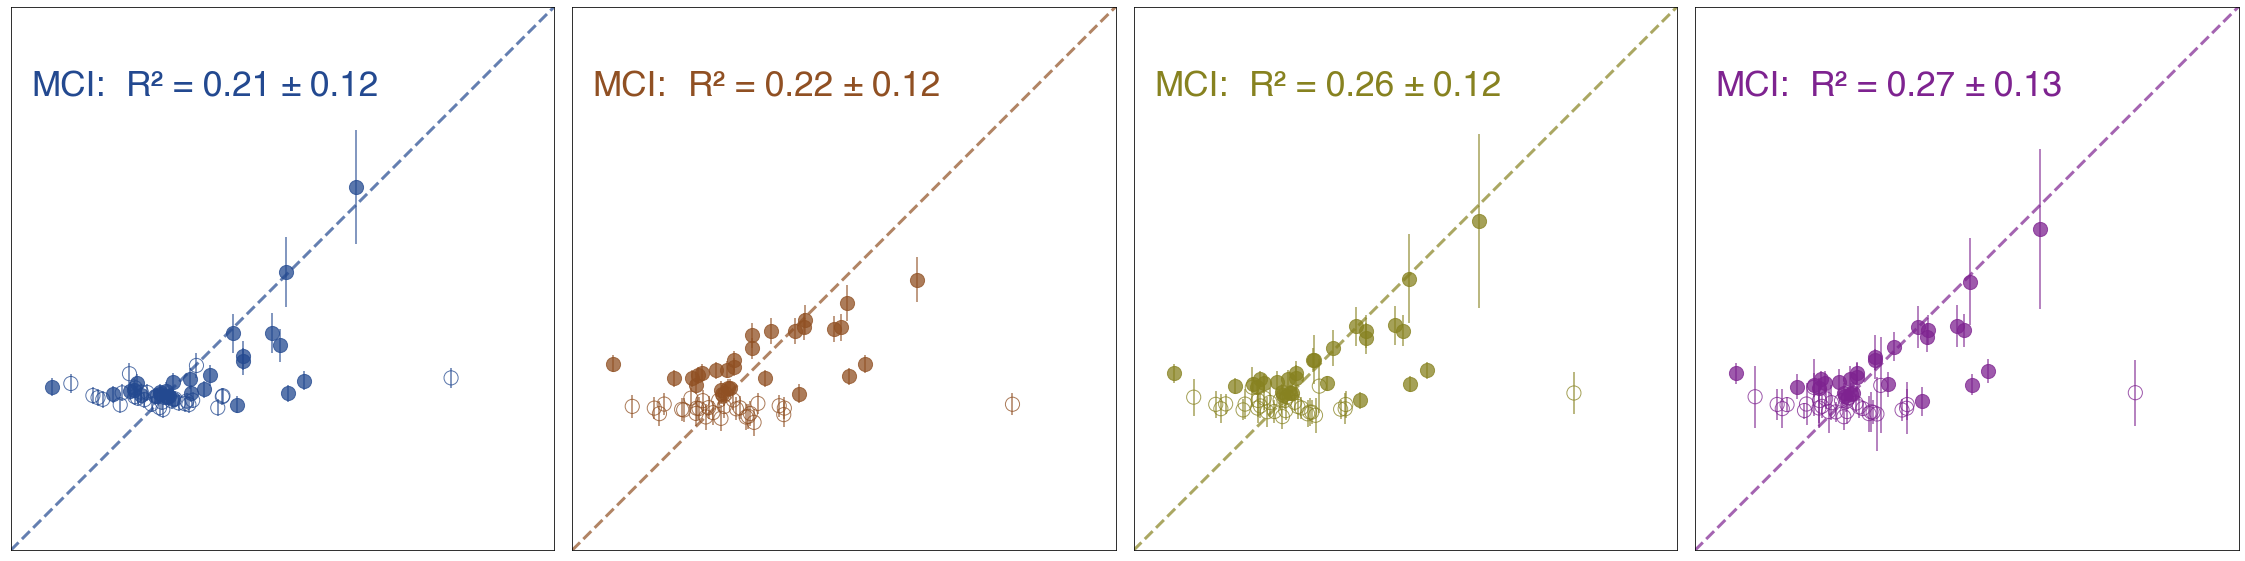

In [286]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'MCI'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[:4]), 
                                      weight_variable_by_region_area=True)

    markers = ['o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
#     plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
#     plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
    plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
    plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M1_regions-1-4_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

### NDM regions 4-8

0.47 ,0.19
0.46 ,0.15
0.54 ,0.17
0.59 ,0.17


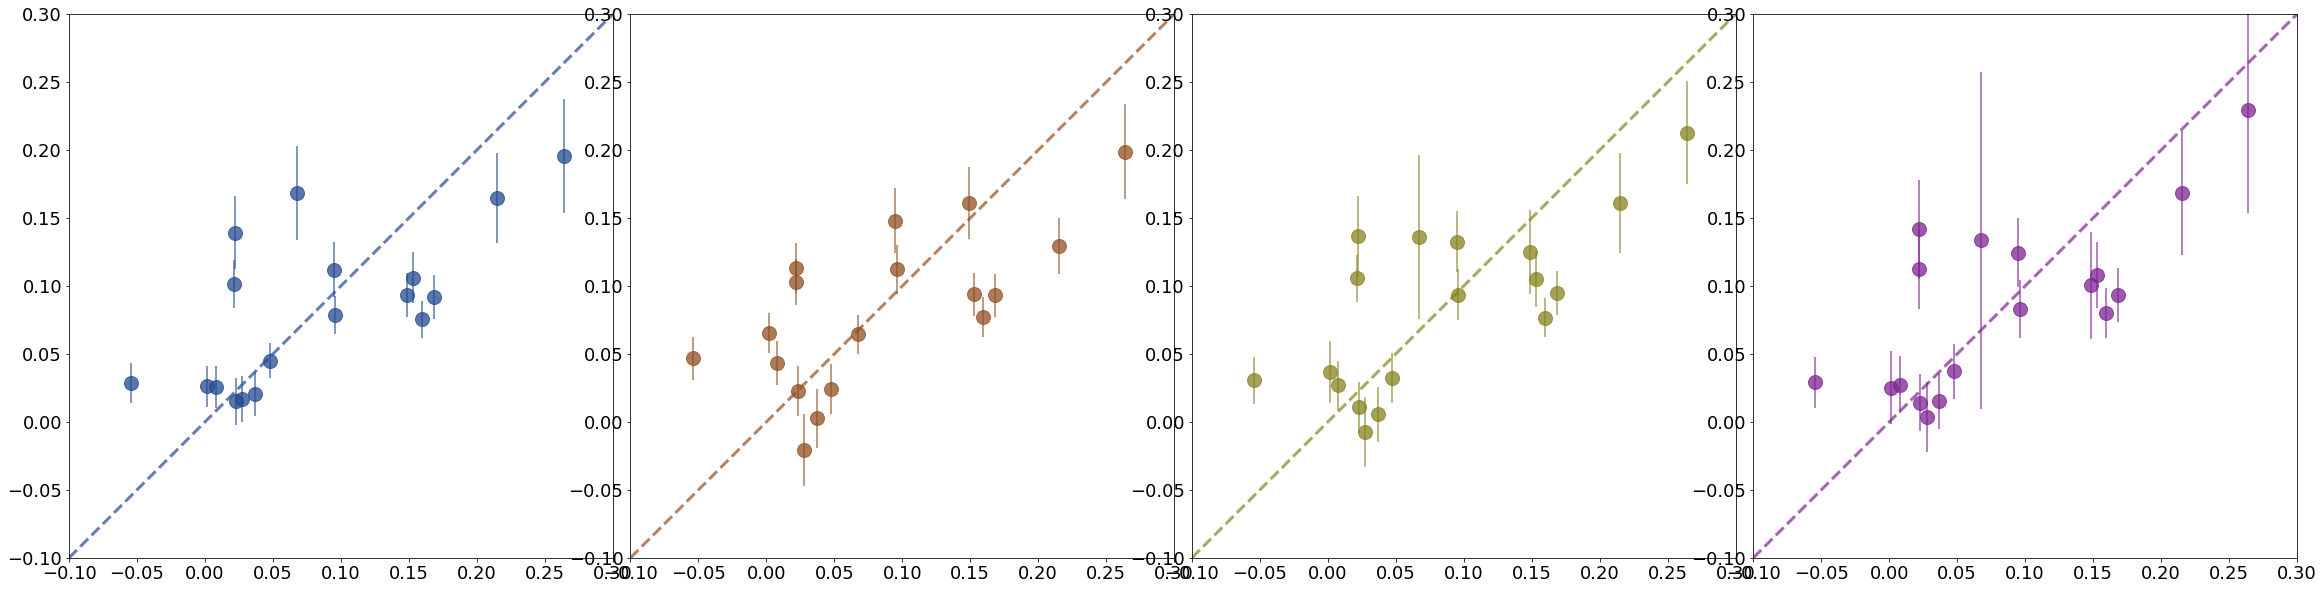

In [114]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'AD'
amyloid_status = 'positive'
plot_with_ticks = True
plot = True

for m in range(4):
    model = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[1:4]), 
                                      weight_variable_by_region_area=True)
   
    X, Y = model['X'], model['Y']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()
    
    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()
    
    print('{:.2f}'.format(mean_score), ',{:.2f}'.format(std_score))
    
    if plot == True:
        plt.subplot(1,4,m+1, aspect=1.0)
        plt.subplots_adjust(wspace=0.025)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if not plot_with_ticks:
            plt.xticks([])
            plt.yticks([])

        plt.errorbar(Y.ravel(), means, stds, xerr=None, fmt='o', color=colors[m], ms=14, alpha=0.75)

        plt.xlim([-0.10,0.3])
        plt.ylim([-0.10,0.3])
        plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

$R^2$ = 0.44 $R^2$ = 0.14
$R^2$ = 0.41 $R^2$ = 0.10
$R^2$ = 0.51 $R^2$ = 0.12
$R^2$ = 0.53 $R^2$ = 0.12


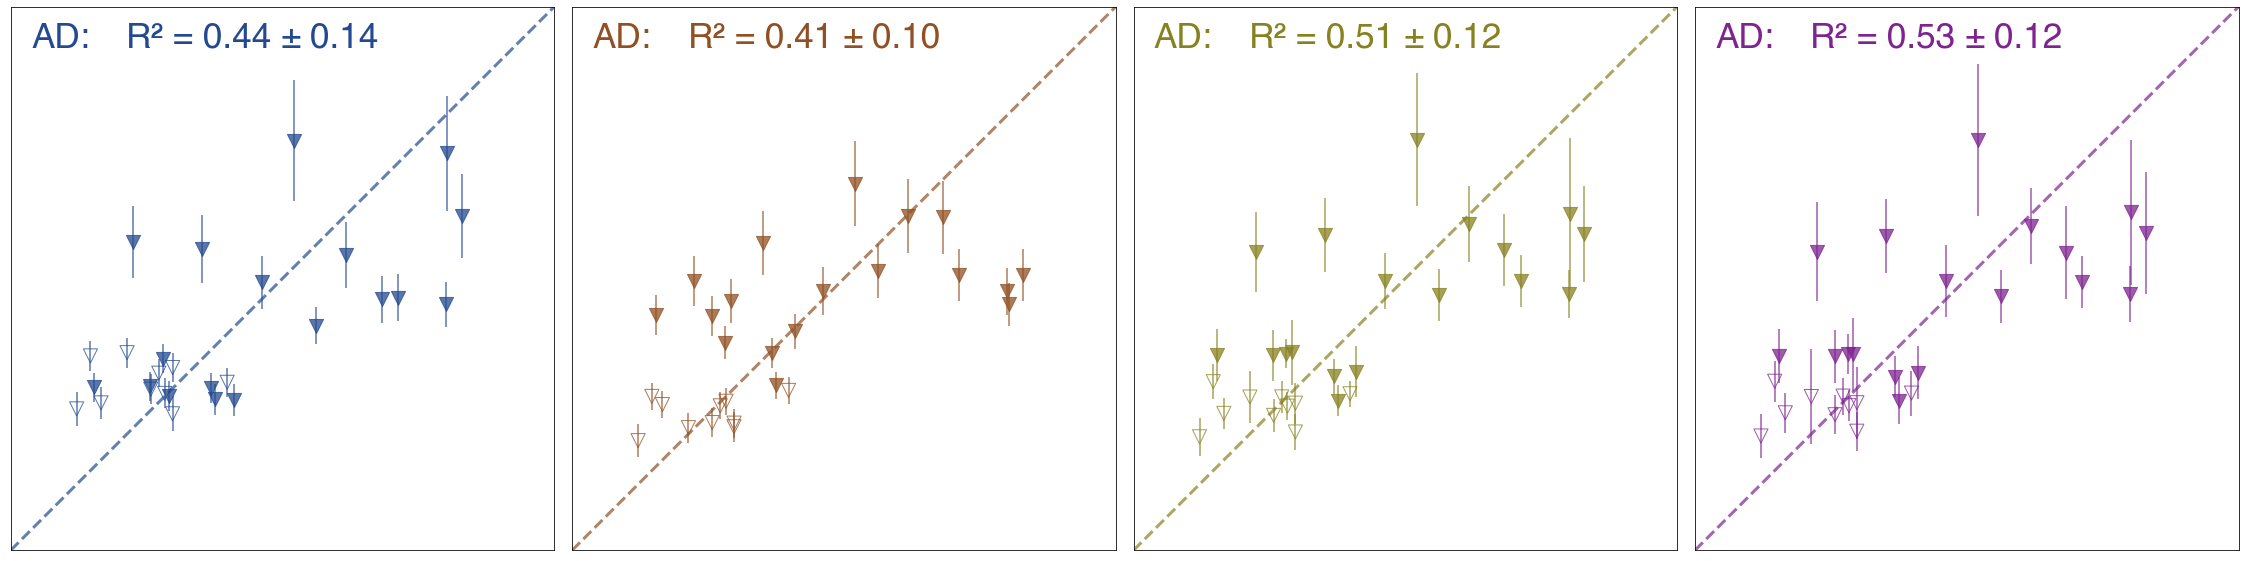

In [287]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'AD'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[4:8]), 
                                      weight_variable_by_region_area=True)

    markers = ['v','v']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['AD']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
    plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
    plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
#     plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
#     plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M1_regions-4-8_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

$R^2$ = 0.47 $R^2$ = 0.24
$R^2$ = 0.43 $R^2$ = 0.12
$R^2$ = 0.57 $R^2$ = 0.17
$R^2$ = 0.65 $R^2$ = 0.16


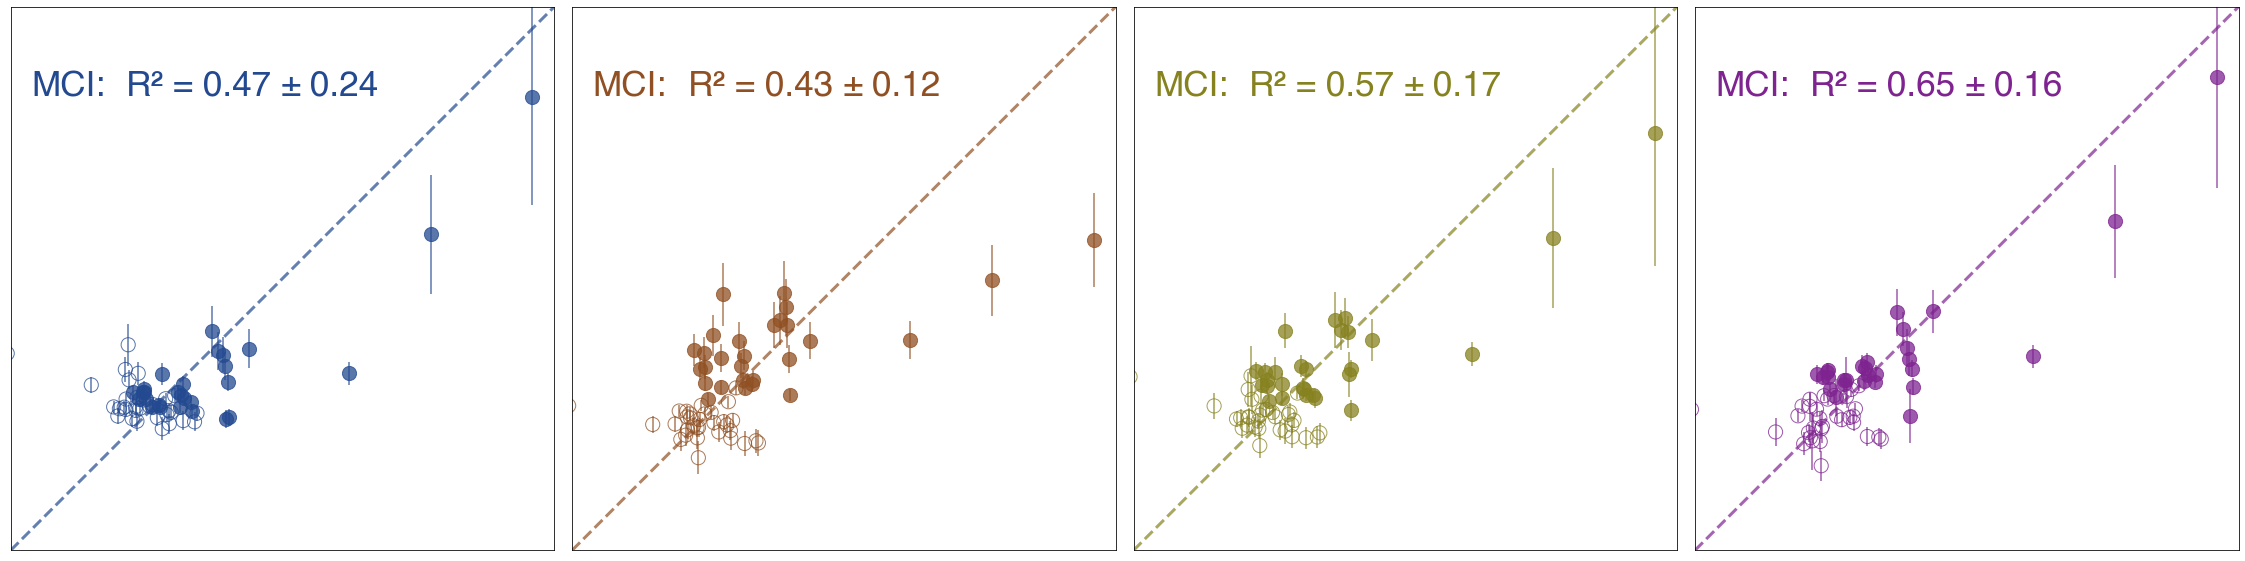

In [288]:
plt.figure(figsize=(40,10))
colors = ['#234990','#905023','#878220','#7e2390']

clinical_dx = 'MCI'
amyloid_status = 'both'
plot_with_ticks = False

for m in range(4):
    regression_dict = make_regression_variables(clinical_dx=clinical_dx,
                                      amyloid_status=amyloid_status, 
                                      model=m, 
                                      regions_to_average=list(NDM_predicted_regions[4:8]), 
                                      weight_variable_by_region_area=True)

    markers = ['o','o']
    facecolors = [colors[m], 'none', colors[m], 'none']
    
    plt.subplot(1,4,m+1, aspect=1.0)
    plt.subplots_adjust(wspace=0.025)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if not plot_with_ticks:
        plt.xticks([])
        plt.yticks([])
    
    plt.xlim([-0.10,0.3])
    plt.ylim([-0.10,0.3])
    plt.plot([-0.10,0.3],[-0.10,0.3],'--', color=colors[m], linewidth=3, alpha=0.7)

    cohort = select_subset_of_regression_variables(regression_dict, clinical_dx=clinical_dx, 
                                  amyloid_status=amyloid_status)

    X, Y, idx = cohort['X'], cohort['Y'], cohort['idx']

    bootstrapped_data = calculate_bootstrap_samples(X=X, Y=Y)
    scores = np.array(bootstrapped_data['scores'])
    mean_score = scores.mean()
    std_score = scores.std()

    preds = bootstrapped_data['predictions']
    means = preds.mean(axis=1).ravel()
    stds = preds.std(axis=1).ravel()

    print(r'$R^2$ = {:.2f}'.format(mean_score), r'$R^2$ = {:.2f}'.format(std_score))
    plt.errorbar(Y.ravel(), means, stds, xerr=None,  fmt='none', mec=colors[m], ecolor=colors[m], ms=14, alpha=0.75)

    i=0
    for ad in ['MCI']:
        for amyloid in ['positive', 'negative']:
            
            bootstrapped_dict = {'true_value':Y, 'prediction':means, 'idx':idx}
            select_cohort = select_subset_of_regression_variables(bootstrapped_dict, 
                                                 clinical_dx=ad, 
                                                 amyloid_status=amyloid)
          
            plt.scatter(select_cohort['true_value'], select_cohort['prediction'], marker=markers[i], facecolors=facecolors[i], color=colors[m], s=200, alpha=0.75)

            i = i+1

    fontdict={'fontname':'Helvetica', 'size':35, 'color':colors[m]}
#     plt.text(-0.085,0.270, 'AD:', fontdict=fontdict)
#     plt.text(-0.015,0.270, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)
    plt.text(-0.085,0.235, 'MCI:', fontdict=fontdict)
    plt.text(-0.015,0.235, "R² = "+'{:.2f}'.format(mean_score)+" ± " + '{:.2f}'.format(std_score), fontdict=fontdict)

figure_name = '../results/notebook_figs/M1_regions-4-8_dx-' + clinical_dx + '_abeta-' + amyloid_status + '_tick_' + str(plot_with_ticks)

plt.savefig(figure_name, dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)

In [217]:
plt.show()

In [128]:
markers = ['v','v','o','o']
colors = ['#234990','#905023','#878220','#7e2390']
facecolors = [colors[m], 'none', colors[m], 'none']

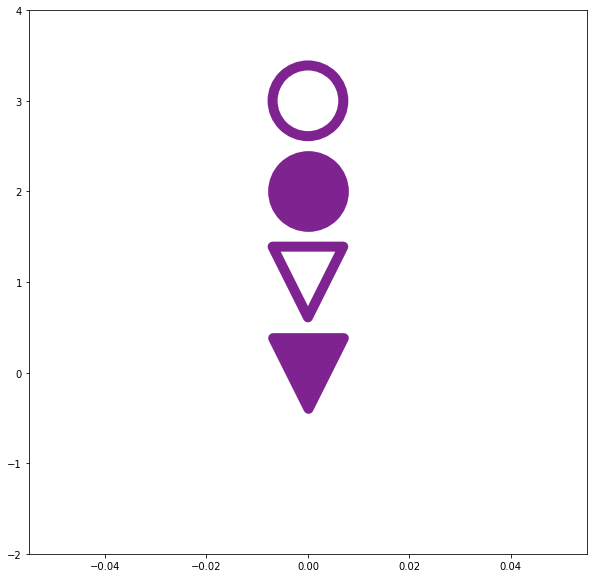

In [143]:
plt.figure(figsize=(10,10))
plt.ylim([-2,4])
for i in range(4):
    plt.scatter(0,i, marker=markers[i], facecolors=facecolors[i], color=colors[m], s=5000, alpha=1.0, linewidths=10)
plt.savefig('../results/notebook_figs/legend.png', dpi=150, transparent=True, bbox_inches = 'tight', pad_inches = 0.1)